# Comparing three different methods for modulating the wave through the phantom

(1) Chromatix Multislice (multislice_thick_sample)

(2) Projection Approximation (thin_sample)

(3) Sequentially Applying the Projection Approximation (thin_sample in a for loop)


The ideal output is produced by (3). In theory, (1) should produce similar output to (3), while (2) should produce totally different output. 

However, (1) produces output nearly identical to (2). Meanwhile, (3) produces different output as expected. 

We would like to figure out what is going wrong with (1) and fix it. 

### Prelims

In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from src.spectral_xpci.xscatter import get_delta_beta_mix, get_wavelen
from chromatix.ops import init_plane_resample
import chromatix.functional as cx

In [2]:
class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

pmma = Material('PMMA', 'H(8.06)C(59.98)O(31.96)', 1.19)
nylon = Material('nylon', 'H(9.7980)C(63.6853)N(12.3779)O(14.1388)', 1.15)

def make_fiber_phantom(N, Nz, dx, fiber_width, energy, 
                       fiber_material=nylon, background_material=pmma, height_fraction=0.8):
    fov = N*dx
    fiber_height = height_fraction*fov
    coords = np.abs(np.linspace(-fov/2, fov/2, N))
    X, Y = np.meshgrid(coords, coords)

    obj = np.zeros([Nz, N, N], dtype=np.uint8)
    for z in range(Nz):
        mask = np.where((X <= fiber_width/2) & (Y <= fiber_height/2))  
        obj[z][mask] = 1

    matdict = {0: background_material, 1: fiber_material}
    obj_delta = jnp.zeros(obj.shape)
    obj_beta = jnp.zeros(obj.shape)
    for mat_id in matdict:
        d, b = matdict[mat_id].delta_beta(energy)
        obj_delta = obj_delta.at[obj == mat_id].set(d)
        obj_beta = obj_beta.at[obj == mat_id].set(b)

    return obj_delta, obj_beta


# Parameters

In [3]:
##########################################
### Parameters 

energy = 20        # beam energy [keV]
propdist = 30e-2 

# Phantom:
N = 1024              # num pixels in x-y plane
dx = 0.625e-6        # phantom resolution
fov = N*dx           # field-of-view in the transverse plane (x-y)
Nz = 10              # num pixels along z axis
thickness = 5e-2     # thickness along propagation axis (z)
dz = thickness/Nz
phantom_shape = jnp.array([Nz, N, N])

# Detector:
det_shape = (128, 128)   
det_dx = fov / det_shape[0]  

# Misc:
N_pad = 100
n_medium = 1
n_avg = 1
key=jax.random.PRNGKey(3)


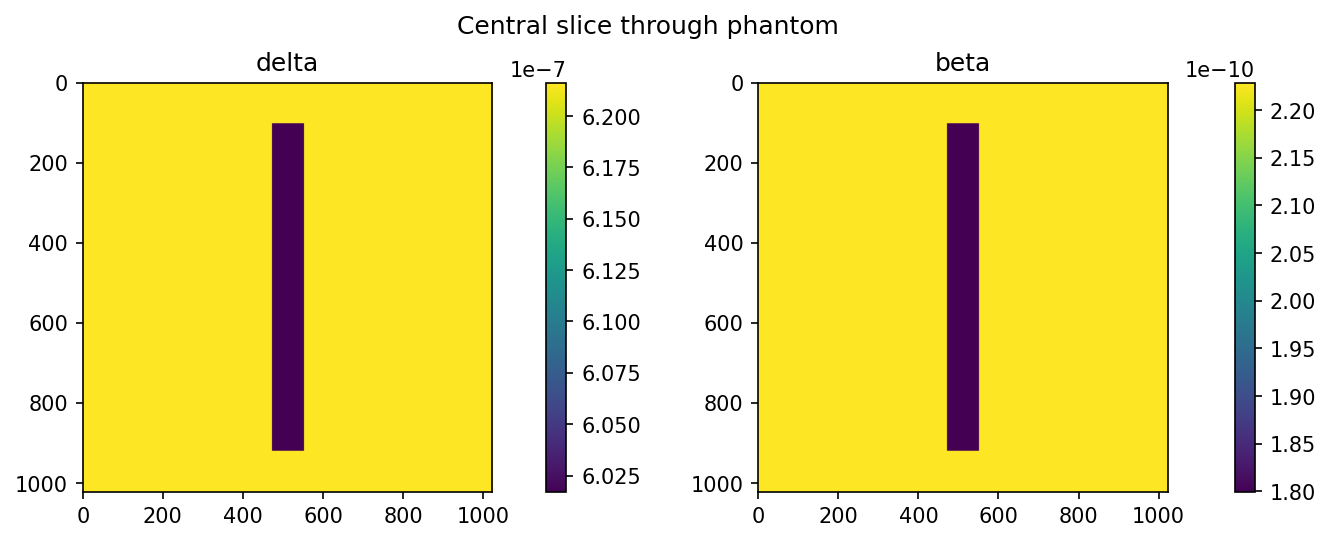

In [4]:
# Generate the phantom.
fiber_width = 50e-6 
obj_delta, obj_beta = make_fiber_phantom(N, Nz, dx, fiber_width, energy)

# Show.
fig, ax = plt.subplots(1, 2, figsize=[9,3.5], layout='constrained', dpi=150)
fig.suptitle('Central slice through phantom')
for i, obj in enumerate([obj_delta, obj_beta]):
    ax[i].set_title(['delta', 'beta'][i])
    m = ax[i].imshow(obj[obj.shape[0]//2,:,:])  
    fig.colorbar(m, ax=ax[i], pad=0)
plt.show()    

# Simulations

In [5]:
%%time

#####
# Incident field.
field = cx.plane_wave(
    shape = phantom_shape[1:], 
    dx = dx,
    spectrum = get_wavelen(energy),
    spectral_density = 1.0,
)
field = (field / field.intensity.max()**0.5)
cval = field.intensity.max()


#####
# Three different methods for modulating the wave through the phantom:
exit_fields = []

# method 1: native chromatix function `multislice_thick_sample`
exit_fields.append(
    cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, dz, N_pad)
)

# method 2: sequentially repeating cx functions `thin_sample` and `transfer_propagate`
field_k = field      
for k in range(Nz):
    field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], dz)
    field_k = cx.transfer_propagate(field_k, dz, n_medium, N_pad, cval=cval, mode='same')
exit_fields.append(field_k)

# method 3: projection approximation `thin_sample` only.
beta_proj = dz * jnp.sum(obj_beta, axis=0)
delta_proj = dz * jnp.sum(obj_delta, axis=0)
exit_fields.append(
    cx.thin_sample(field, beta_proj[None, ..., None, None], delta_proj[None, ..., None, None], 1.0)
)


#####
# Apply the same free-space propagation method for each exit field:
imgs = []
for exit_field in exit_fields:
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    img = img / (det_dx/dx)**2  # normalize counts to new pixel size
    imgs.append(img)


#####
# Extract the final images:
img_ms_chromatix = imgs[0]   # chromatix multislice
img_ms_seq = imgs[1]         # sequential multislice + propagation
img_approx = imgs[2]         # projection approximation only


CPU times: user 5.84 s, sys: 860 ms, total: 6.7 s
Wall time: 4.46 s


# Results for the three simulations

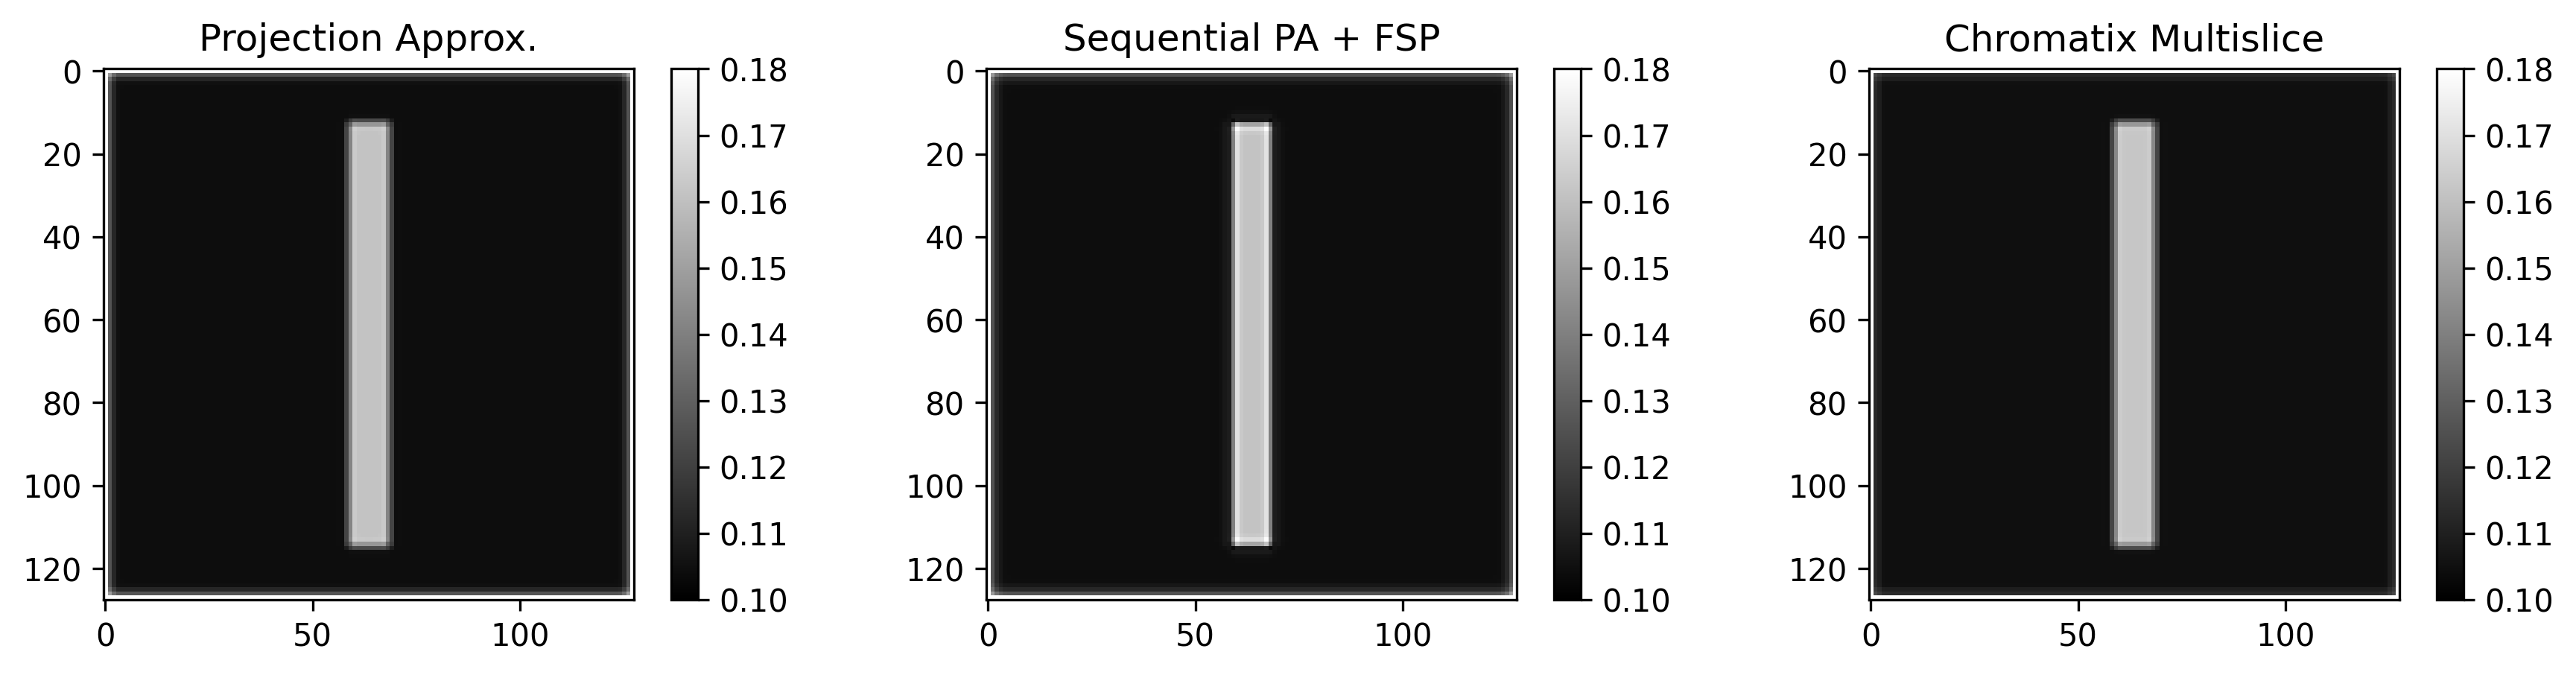

In [6]:
# Full images

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=[12,3], dpi=300)
kw = {'cmap':'gray', 'vmin':0.1, 'vmax':0.18}


ax[0].set_title('Projection Approx.')
m = ax[0].imshow(img_approx, **kw)
fig.colorbar(m, ax=ax[0])

ax[1].set_title('Sequential PA + FSP')
m = ax[1].imshow(img_ms_seq, **kw)
fig.colorbar(m, ax=ax[1])

ax[2].set_title('Chromatix Multislice')
m = ax[2].imshow(img_ms_chromatix, **kw)
fig.colorbar(m, ax=ax[2])


fig.tight_layout()
plt.show()

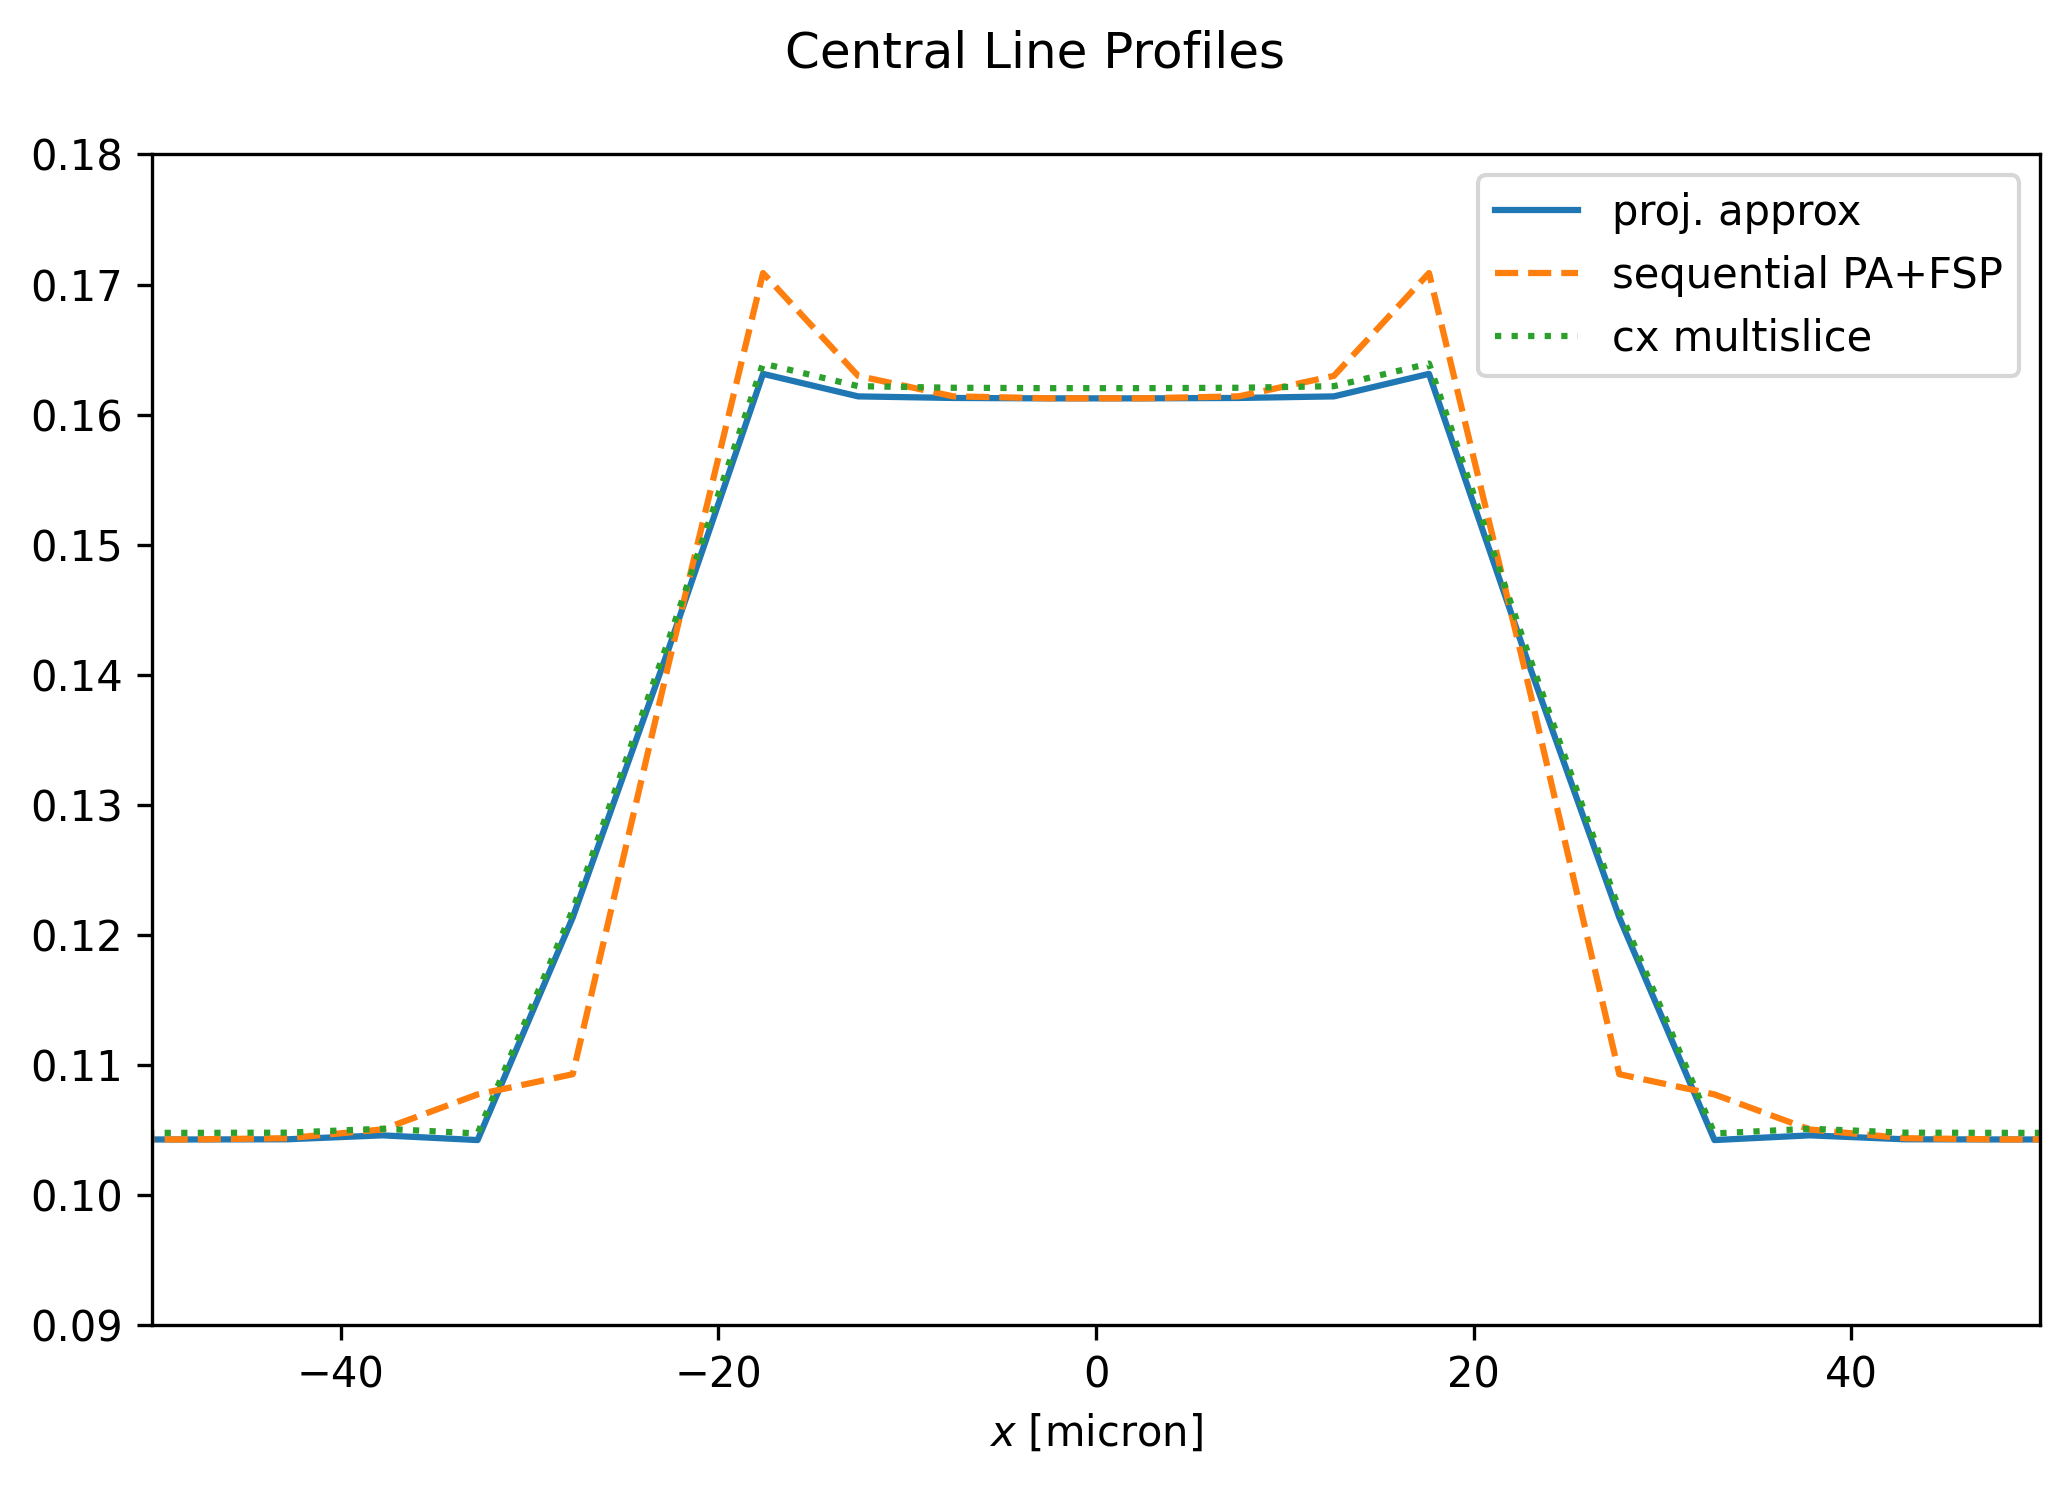

In [7]:
# Central line profiles better show the difference at the edges.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7,5], dpi=300)

fig.suptitle('Central Line Profiles')
i_row = int((det_shape[0])/2)  
x = 1e6 * np.linspace(-fov/2, fov/2, det_shape[0])
ax.set_xlabel('$x$ [micron]')
ax.set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
ax.set_ylim(0.09, 0.18)
ax.plot(x, img_approx[i_row], linestyle='-', label='proj. approx') 
ax.plot(x, img_ms_seq[i_row], linestyle='--', label='sequential PA+FSP')  
ax.plot(x, img_ms_chromatix[i_row], linestyle=':', label='cx multislice')
ax.legend()
fig.tight_layout()
plt.show()

### Questions for Jan

* Why does `img_ms_seq` not match `img_ms_chromatix`? Visually comparing the outputs, `img_ms_chromatix` appears much more like `img_approx` than we expected.

* Which of the three padding calculator functions from chromatix.functional.propagation should we use: "exact", "transfer", or "transform"? https://chromatix.readthedocs.io/en/latest/api/functional/#chromatix.functional.propagation.compute_padding_exact 

* What is the difference between "absorption stack" and "absorption", and likewise the difference between "dn stack" and "dn"? Specifically within the context of the two functions "multislice_thick_sample" and "thin_sample". https://chromatix.readthedocs.io/en/latest/api/functional/#chromatix.functional.samples.multislice_thick_sample 

### To-Do List for Cailey

So I'll look into it more in-depth later, but here's a few quick answers / things you can try:

* Experiment with **Padding** (done, no change)

Which of the three padding calculator functions from chromatix.functional.propagation should we use: "exact", "transfer", or "transform"?
That depends on the internal propagation model. These functions give you different paddings depending on the underlying model. There's no hard optimal choice, and in practice we usually just pick a large enough number and check the model doesn't change too much if we change it a little bit.

Test padding with that approach to confirm our value of 100 is large enough, changing the value a little bit and checking that the model doesn't change too much. Then we should look at the source code.
Another tip in terms of sizes and padding: it's all fourier transforms, and those get a lot faster if your shape is a power of 2.
I.e. try and use shapes, padding etcs to get sizes like 256, 512, 1024
(i.e. 1024 sample, 512 padding for example)
1024 + 256 = 1280 is the next best speed
But try and avoid weird stuff like 1200 or 1300 for example

* I think the multislice standard backpropagates towards the center of the sample, as thats usually where the lens is focused. This isn't an issue for you though so turn that off.  (done, no change)

* Other thing could be the **order**; I think we do propagation and then phase change, you might do the other way around. I'd suggest looking at the source code in chromatix, it should be fairly readable.

* Then, look at source code of both chromatix functions and compare the code to the physics functions. Learn physics math and compare to code. 

## Experimenting with Padding

In [8]:
#####
# Incident field.
field = cx.plane_wave(
    shape = phantom_shape[1:], 
    dx = dx,
    spectrum = get_wavelen(energy),
    spectral_density = 1.0,
)
field = (field / field.intensity.max()**0.5)
cval = field.intensity.max()


In [9]:
exact_padding = cx.compute_padding_exact(phantom_shape[1:][0], get_wavelen(energy), dx, thickness)
print("exact padding: ", exact_padding)

exact_padding = cx.compute_padding_transfer(phantom_shape[1:][0], get_wavelen(energy), dx, thickness)
print("transfer padding: ", exact_padding)

exact_padding = cx.compute_padding_transform(phantom_shape[1:][0], get_wavelen(energy), dx, thickness)
print("transform padding: ", exact_padding)

exact padding:  1024
transfer padding:  1024
transform padding:  1024


In [10]:
# N = 1024 already from params block above

N_pad = 256

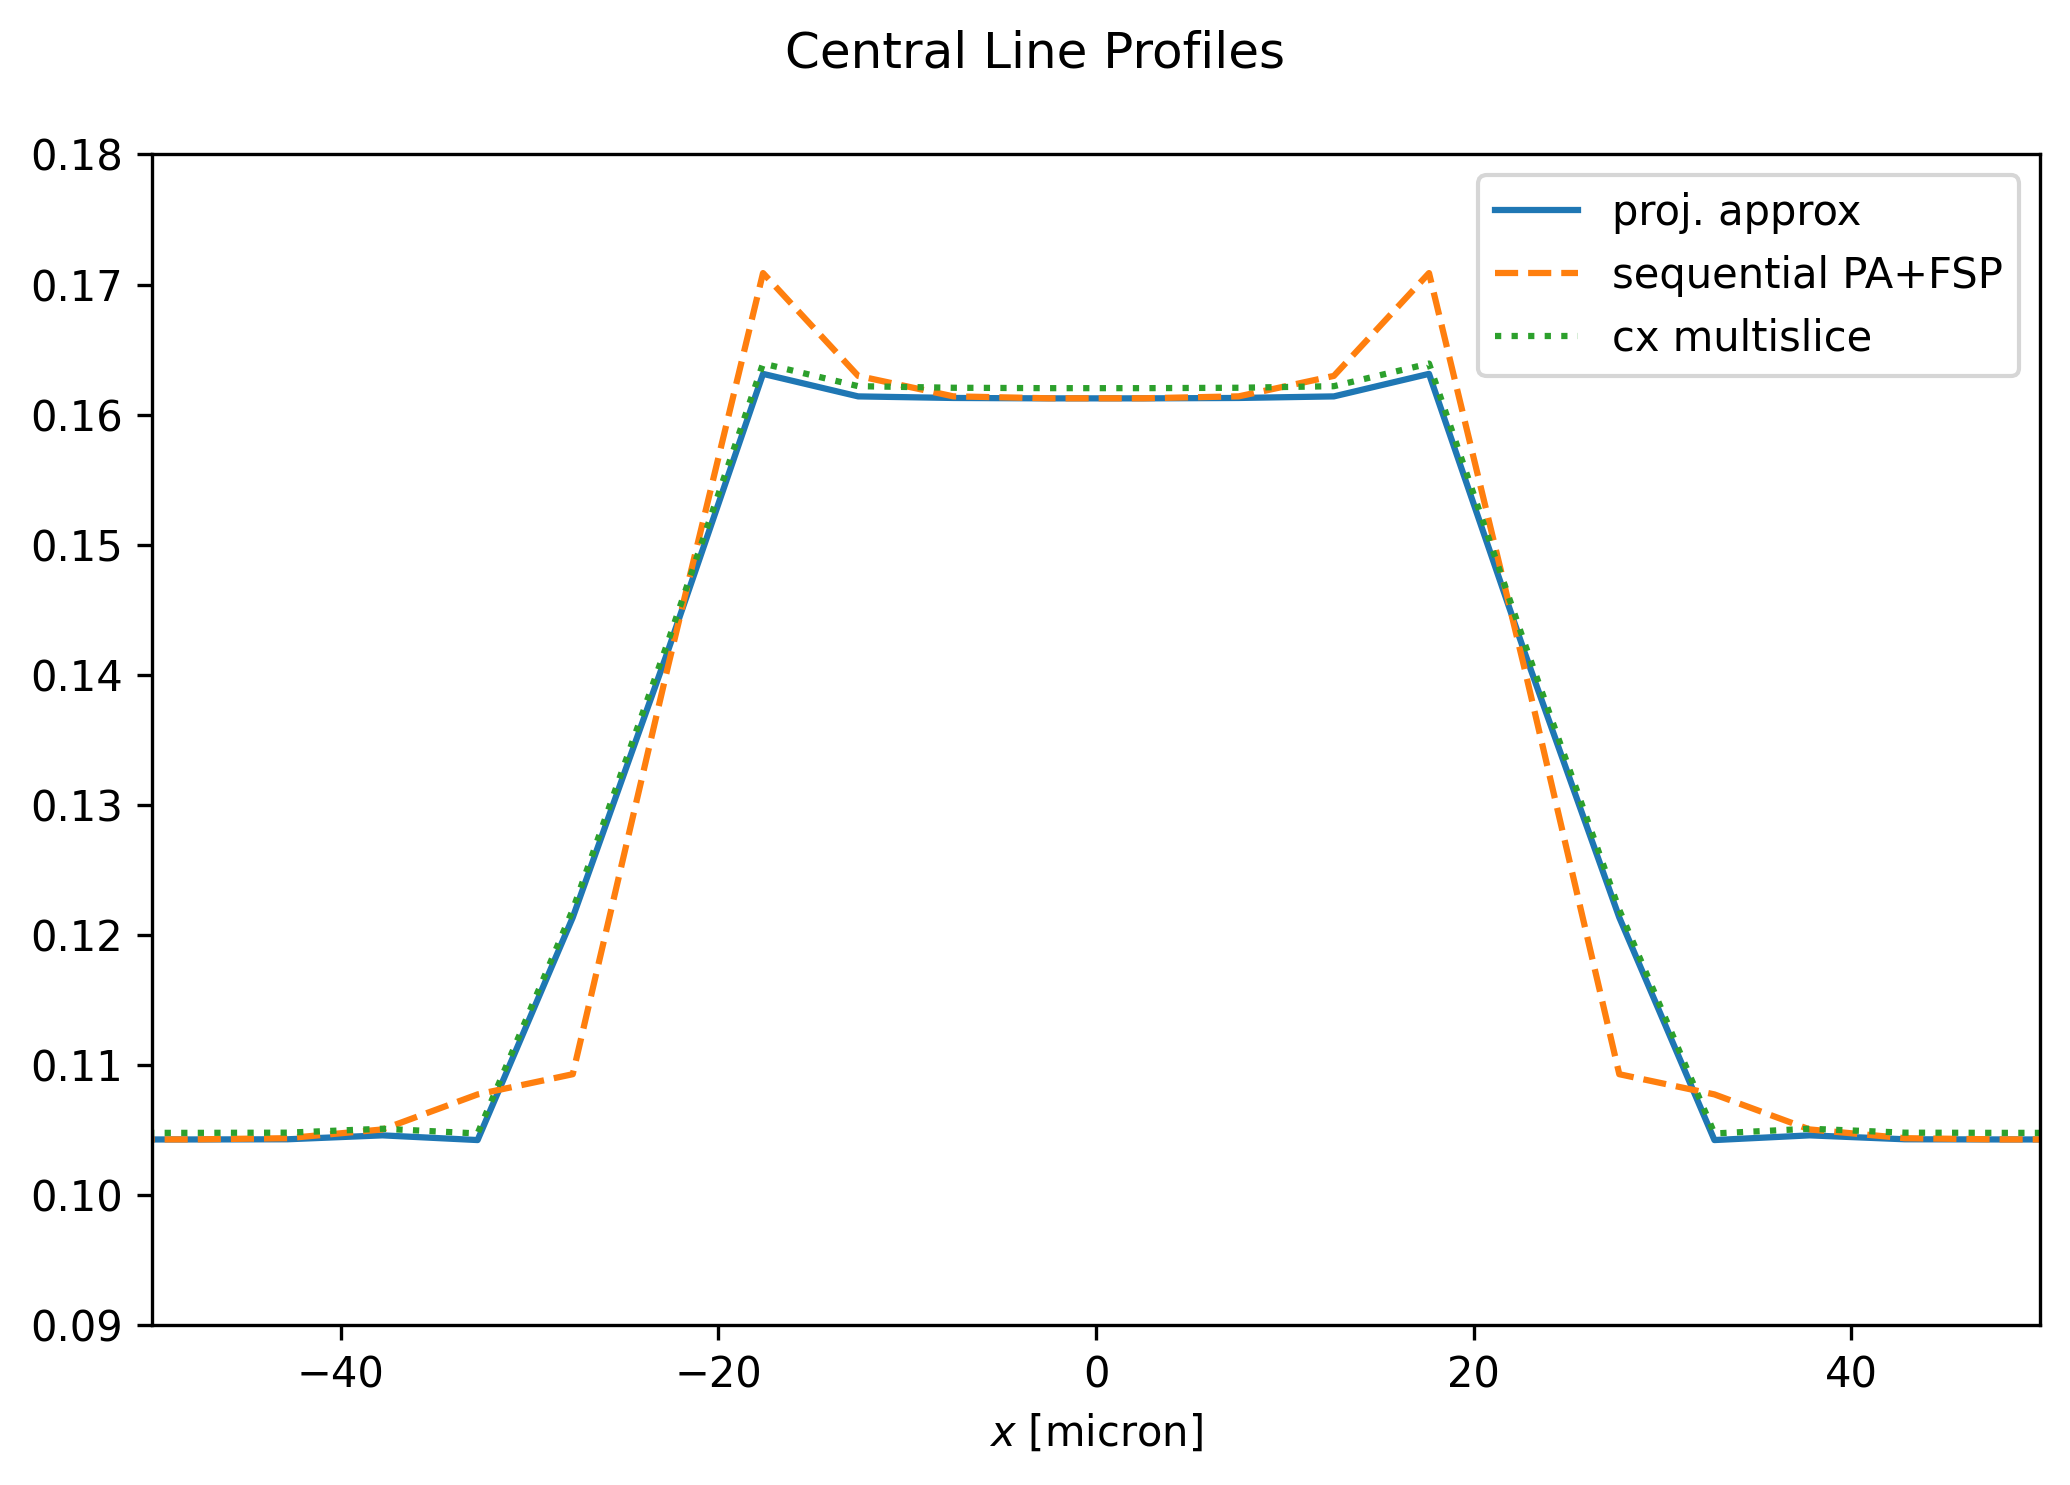

CPU times: user 4.55 s, sys: 975 ms, total: 5.52 s
Wall time: 3.04 s


In [11]:
%%time

#####
# Three different methods for modulating the wave through the phantom:
exit_fields = []

# method 1: native chromatix function `multislice_thick_sample`
exit_fields.append(
    cx.multislice_thick_sample(field, obj_beta, obj_delta, n_avg, dz, N_pad)   # maybe reverse_propagate_distance=0 
)

# method 2: sequentially repeating cx functions `thin_sample` and `transfer_propagate`
field_k = field      
for k in range(Nz):
    field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], dz)
    field_k = cx.transfer_propagate(field_k, dz, n_medium, N_pad, cval=cval, mode='same')
exit_fields.append(field_k)

# method 3: projection approximation `thin_sample` only.
beta_proj = dz * jnp.sum(obj_beta, axis=0)
delta_proj = dz * jnp.sum(obj_delta, axis=0)
exit_fields.append(
    cx.thin_sample(field, beta_proj[None, ..., None, None], delta_proj[None, ..., None, None], 1.0)
)


#####
# Apply the same free-space propagation method for each exit field:
imgs = []
for exit_field in exit_fields:
    det_field = cx.transfer_propagate(exit_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    img = img / (det_dx/dx)**2  # normalize counts to new pixel size
    imgs.append(img)


#####
# Extract the final images:
img_ms_chromatix = imgs[0]   # chromatix multislice
img_ms_seq = imgs[1]         # sequential multislice + propagation
img_approx = imgs[2]         # projection approximation only


# Central line profiles better show the difference at the edges.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7,5], dpi=300)

fig.suptitle('Central Line Profiles')
i_row = int((det_shape[0])/2)  
x = 1e6 * np.linspace(-fov/2, fov/2, det_shape[0])
ax.set_xlabel('$x$ [micron]')
ax.set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
ax.set_ylim(0.09, 0.18)
ax.plot(x, img_approx[i_row], linestyle='-', label='proj. approx') 
ax.plot(x, img_ms_seq[i_row], linestyle='--', label='sequential PA+FSP')  
ax.plot(x, img_ms_chromatix[i_row], linestyle=':', label='cx multislice')
ax.legend()
fig.tight_layout()
plt.show()


## Experimenting with Order

In [14]:
%%time

N_pad = 1024

#####
# Incident fields.
field = cx.plane_wave(
    shape = phantom_shape[1:], 
    dx = dx,
    spectrum = get_wavelen(energy),
    spectral_density = 1.0,
)
field = (field / field.intensity.max()**0.5)
cval = field.intensity.max()

incident_fields = [field, field, field]





#####
# Apply the same free-space propagation method for each INCIDENT field:
propagated_fields = []
for inc_field in incident_fields:
    det_field = cx.transfer_propagate(inc_field, propdist, n_medium, N_pad, cval=cval, mode='same')
    det_resample_func = init_plane_resample(det_shape, (det_dx, det_dx), resampling_method='linear')
    img = det_resample_func(det_field.intensity.squeeze()[...,None,None], field.dx.ravel()[:1])[...,0,0]
    img = img / (det_dx/dx)**2  # normalize counts to new pixel size
    propagated_fields.append(img)






#####
# Three different methods for modulating the wave through the phantom:
exit_fields = []

# method 1: native chromatix function `multislice_thick_sample`
exit_fields.append(
    cx.multislice_thick_sample(propagated_fields[0], obj_beta, obj_delta, n_avg, dz, N_pad)   # maybe reverse_propagate_distance=0 
)

# method 2: sequentially repeating cx functions `thin_sample` and `transfer_propagate`
field_k = propagated_fields[1]      
for k in range(Nz):
    field_k = cx.thin_sample(field_k, obj_beta[k][None, ..., None, None], obj_delta[k][None, ..., None, None], dz)
    field_k = cx.transfer_propagate(field_k, dz, n_medium, N_pad, cval=cval, mode='same')
exit_fields.append(field_k)

# method 3: projection approximation `thin_sample` only.
beta_proj = dz * jnp.sum(obj_beta, axis=0)
delta_proj = dz * jnp.sum(obj_delta, axis=0)
exit_fields.append(
    cx.thin_sample(propagated_fields[2], beta_proj[None, ..., None, None], delta_proj[None, ..., None, None], 1.0)
)



AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'u'

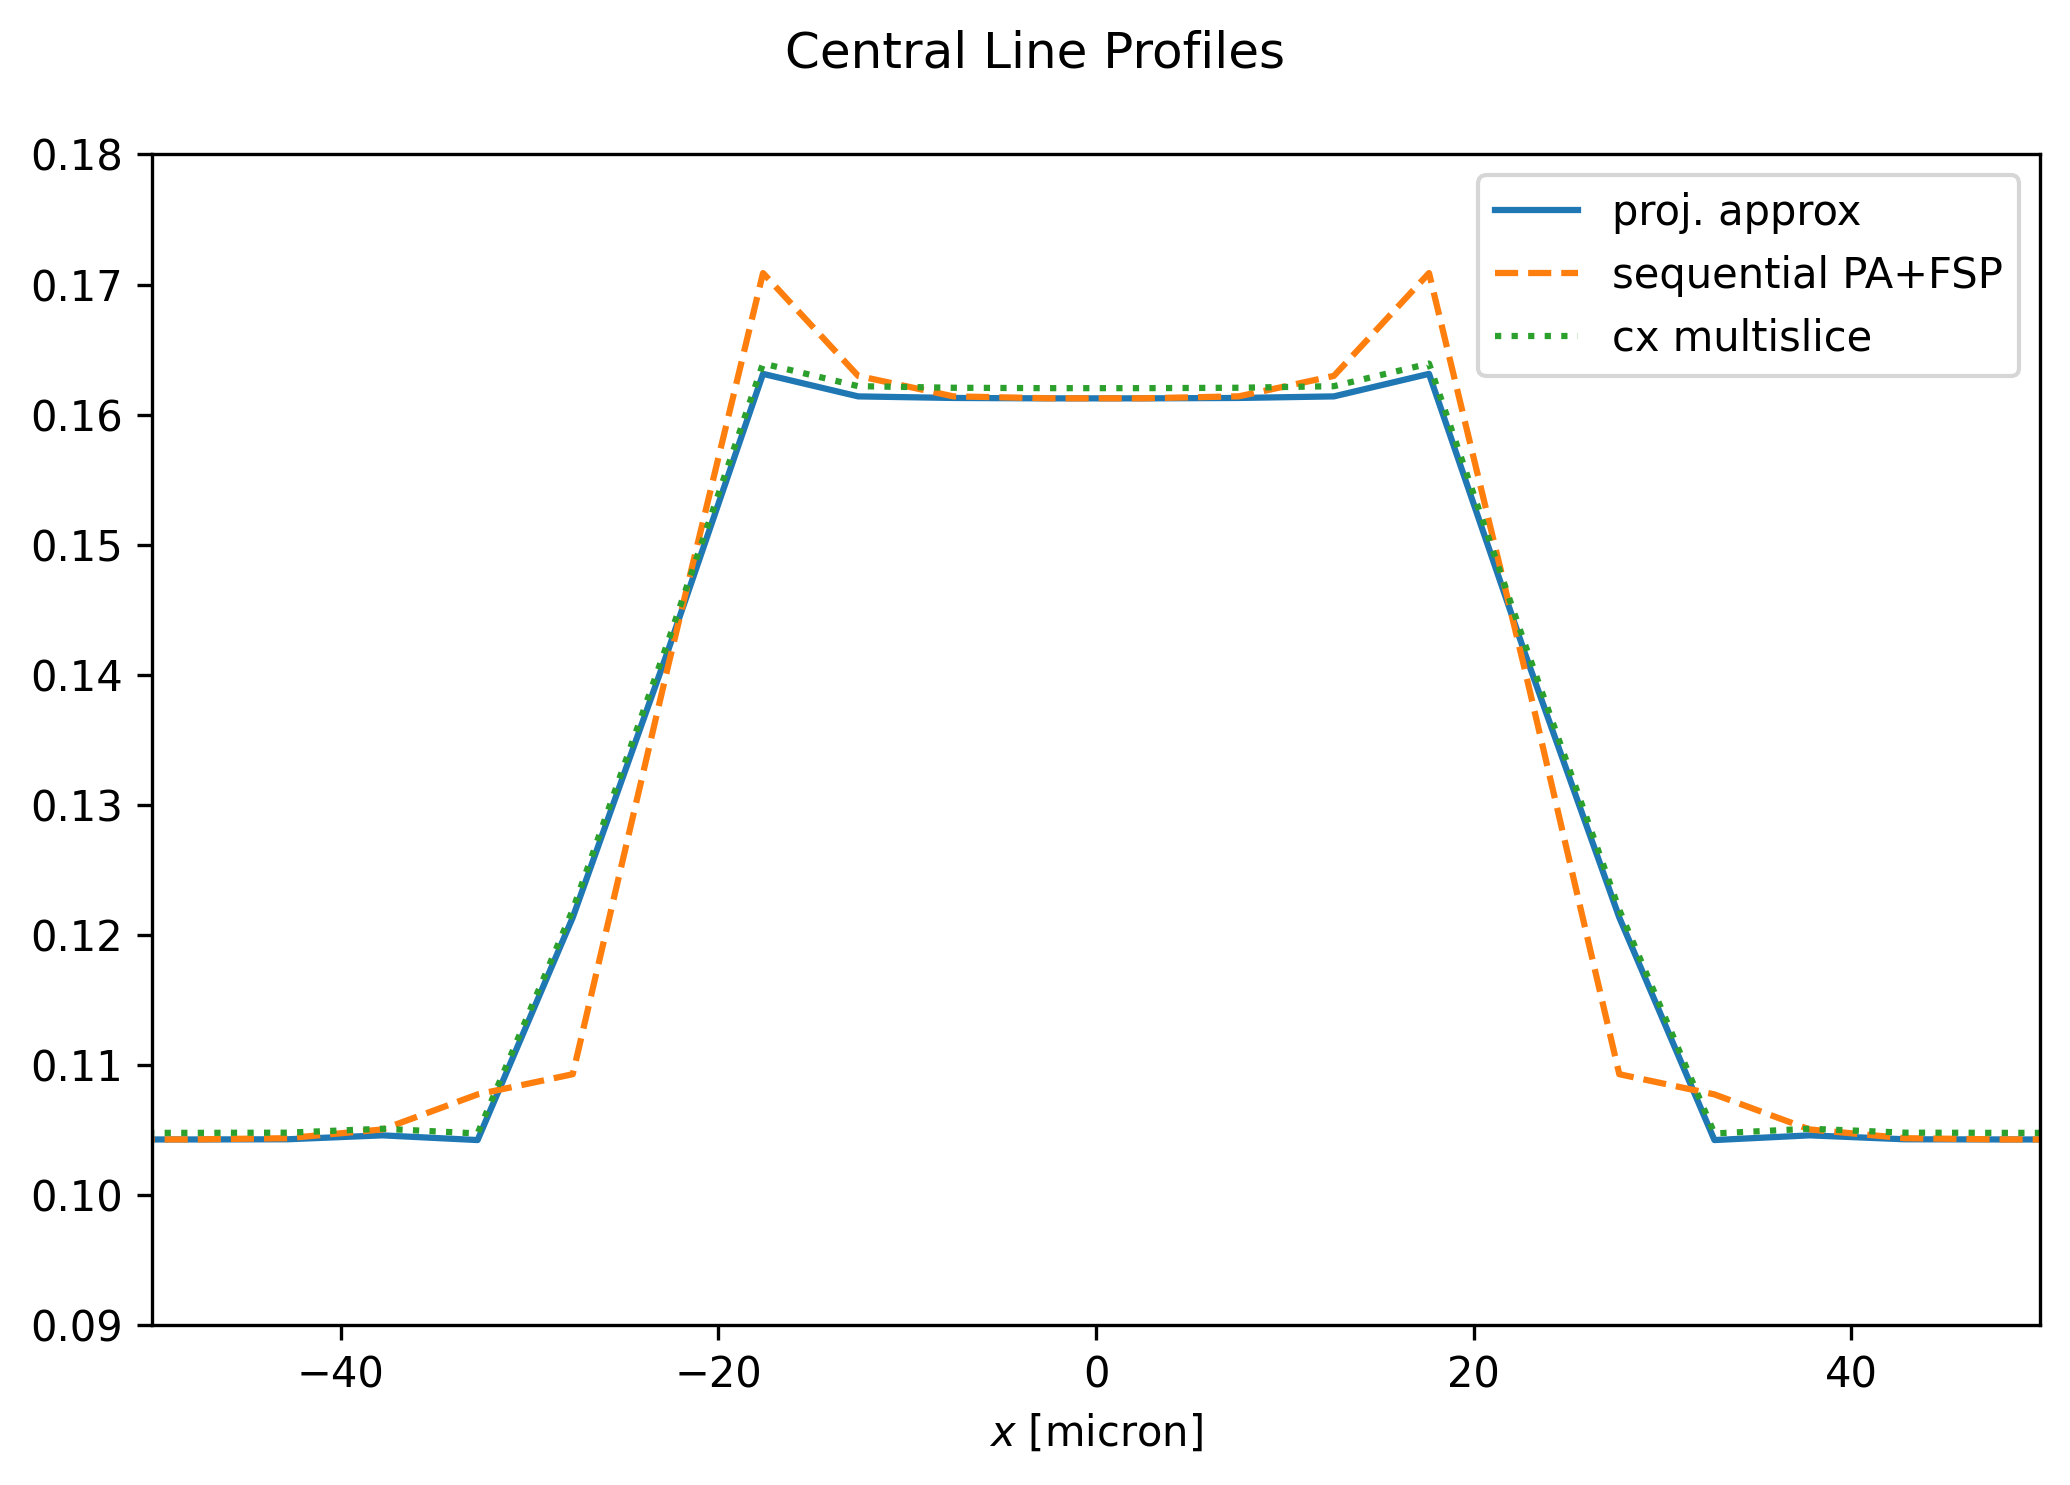

In [ ]:
#####
# Extract the final images:
img_ms_chromatix = exit_fields[0]   # chromatix multislice
img_ms_seq = exit_fields[1]         # sequential multislice + propagation
img_approx = exit_fields[2]         # projection approximation only


# Central line profiles better show the difference at the edges.

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[7,5], dpi=300)

fig.suptitle('Central Line Profiles')
i_row = int((det_shape[0])/2)  
x = 1e6 * np.linspace(-fov/2, fov/2, det_shape[0])
ax.set_xlabel('$x$ [micron]')
ax.set_xlim(-fiber_width*1e6, fiber_width*1e6)  # zoom into the fiber width
ax.set_ylim(0.09, 0.18)
ax.plot(x, img_approx[i_row], linestyle='-', label='proj. approx') 
ax.plot(x, img_ms_seq[i_row], linestyle='--', label='sequential PA+FSP')  
ax.plot(x, img_ms_chromatix[i_row], linestyle=':', label='cx multislice')
ax.legend()
fig.tight_layout()
plt.show()